In [1]:
# Information Retrieval Search Engine with Clustering
# Simple function-based approach

%pip install nltk scikit-learn numpy python-Levenshtein rank-bm25 datasets matplotlib seaborn -q

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


True

In [2]:
# Import libraries
import string
import numpy as np
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Levenshtein import distance as levenshtein_distance
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


In [3]:
# Load dataset
from datasets import load_dataset, concatenate_datasets

full_dataset_dict = load_dataset("taln-ls2n/inspec")
dataset_to_eval = concatenate_datasets([
    full_dataset_dict['train'], 
    full_dataset_dict['validation'], 
    full_dataset_dict['test']
])

print(f"Dataset loaded: {len(dataset_to_eval)} documents")
print(f"Sample document keys: {list(dataset_to_eval[0].keys())}")
print(f"Sample title: {dataset_to_eval[0]['title']}")


Dataset loaded: 2000 documents
Sample document keys: ['id', 'title', 'abstract', 'keyphrases', 'prmu']
Sample title: Towards a NMR implementation of a quantum lattice gas algorithm


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [4]:
# Function 1: Text Preprocessing
def preprocess(text):
    """Preprocess text: tokenize, lowercase, remove stopwords, stem"""
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Test preprocessing
test_text = "Computer Vision and Machine Learning algorithms"
print(f"Original: {test_text}")
print(f"Processed: {preprocess(test_text)}")


Original: Computer Vision and Machine Learning algorithms
Processed: ['comput', 'vision', 'machin', 'learn', 'algorithm']


In [5]:
# Function 2: Build Vocabulary
def build_vocabulary(dataset):
    """Build vocabulary from all documents"""
    vocabulary = set()
    for doc in dataset:
        title_tokens = preprocess(doc.get('title', ''))
        abstract_tokens = preprocess(doc.get('abstract', ''))
        keyphrase_tokens = preprocess(' '.join(doc.get('keyphrases', [])))
        vocabulary.update(title_tokens + abstract_tokens + keyphrase_tokens)
    return vocabulary

# Build vocabulary
vocabulary = build_vocabulary(dataset_to_eval)
print(f"Vocabulary size: {len(vocabulary)}")
print(f"Sample words: {list(vocabulary)[:10]}")


Vocabulary size: 8909
Sample words: ['symmetr', 'spectral', 'connot', 'thyristor', 'septal', 'vagu', 'dictionari', 'atm', 'perfect', 'biotechnolog']


In [6]:
# Function 3: Query Correction
def correct_query_word(word, vocabulary):
    """Correct typos in query using Levenshtein distance"""
    if word in vocabulary:
        return word
    min_dist = float('inf')
    corrected_word = word
    for vocab_word in vocabulary:
        dist = levenshtein_distance(word, vocab_word)
        if dist < min_dist:
            min_dist = dist
            corrected_word = vocab_word
    return corrected_word if min_dist <= 3 else word

# Test query correction
test_query = "computer visiom"
corrected = [correct_query_word(word, vocabulary) for word in preprocess(test_query)]
print(f"Original: {test_query}")
print(f"Corrected: {' '.join(corrected)}")


Original: computer visiom
Corrected: comput vision


In [7]:
# Function 4: Setup BM25
def setup_bm25(dataset):
    """Setup BM25 for title, abstract, and keyphrases"""
    tokenized_titles = [preprocess(doc.get('title', '')) for doc in dataset]
    tokenized_abstracts = [preprocess(doc.get('abstract', '')) for doc in dataset]
    tokenized_keyphrases = [preprocess(' '.join(doc.get('keyphrases', []))) for doc in dataset]
    
    bm25_title = BM25Okapi(tokenized_titles) if any(tokenized_titles) else None
    bm25_abstract = BM25Okapi(tokenized_abstracts) if any(tokenized_abstracts) else None
    bm25_keyphrases = BM25Okapi(tokenized_keyphrases) if any(tokenized_keyphrases) else None
    
    return bm25_title, bm25_abstract, bm25_keyphrases

# Setup BM25
bm25_title, bm25_abstract, bm25_keyphrases = setup_bm25(dataset_to_eval)
print("BM25 setup completed")


BM25 setup completed


In [8]:
# Function 5: Setup Clustering
def setup_clustering(dataset, n_clusters=10):
    """Setup document clustering using K-Means"""
    print("Setting up clustering...")
    
    # Combine all text for clustering
    combined_texts = []
    for doc in dataset:
        title = doc.get('title', '')
        abstract = doc.get('abstract', '')
        keyphrases = ' '.join(doc.get('keyphrases', []))
        combined_text = f"{title} {abstract} {keyphrases}"
        combined_texts.append(combined_text)
    
    # Create TF-IDF vectors
    tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_texts)
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=min(n_clusters, len(dataset)), random_state=42, n_init=10)
    doc_clusters = kmeans.fit_predict(tfidf_matrix)
    
    print(f"Clustering completed: {len(set(doc_clusters))} clusters")
    return tfidf_vectorizer, kmeans, doc_clusters

# Setup clustering
tfidf_vectorizer, kmeans, doc_clusters = setup_clustering(dataset_to_eval, n_clusters=10)


Setting up clustering...
Clustering completed: 10 clusters


In [9]:
# Function 6: Find Relevant Clusters
def find_relevant_clusters(query, tfidf_vectorizer, kmeans):
    """Find clusters most relevant to the query"""
    query_vector = tfidf_vectorizer.transform([query])
    similarities = cosine_similarity(query_vector, kmeans.cluster_centers_)[0]
    
    # Get top clusters above threshold
    threshold = 0.1
    relevant_clusters = [i for i, sim in enumerate(similarities) if sim > threshold]
    
    # If no clusters above threshold, return top 3
    if not relevant_clusters:
        relevant_clusters = np.argsort(similarities)[-3:].tolist()
    
    return relevant_clusters

# Test cluster finding
test_query = "machine learning"
relevant_clusters = find_relevant_clusters(test_query, tfidf_vectorizer, kmeans)
print(f"Query: {test_query}")
print(f"Relevant clusters: {relevant_clusters}")


Query: machine learning
Relevant clusters: [1, 9, 3]


In [10]:
# Function 7: Search with Clustering
def search_with_clustering(query, dataset, bm25_title, bm25_abstract, bm25_keyphrases, 
                          tfidf_vectorizer, kmeans, doc_clusters, vocabulary, top_n=10, k=60):
    """Search with clustering boost"""
    print(f"Searching for: '{query}'")
    
    # Preprocess and correct query
    query_tokens = preprocess(query)
    corrected_tokens = [correct_query_word(word, vocabulary) for word in query_tokens]
    
    # Find relevant clusters
    relevant_clusters = find_relevant_clusters(query, tfidf_vectorizer, kmeans)
    print(f"Found {len(relevant_clusters)} relevant clusters")
    
    # Get BM25 scores
    title_rank_map, abstract_rank_map, keyphrase_rank_map = {}, {}, {}
    all_doc_indices = set()
    
    if bm25_title is not None:
        title_scores = bm25_title.get_scores(corrected_tokens)
        title_ranks = np.argsort(title_scores)[::-1]
        title_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(title_ranks)}
        all_doc_indices.update(title_ranks)
    
    if bm25_abstract is not None:
        abstract_scores = bm25_abstract.get_scores(corrected_tokens)
        abstract_ranks = np.argsort(abstract_scores)[::-1]
        abstract_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(abstract_ranks)}
        all_doc_indices.update(abstract_ranks)
    
    if bm25_keyphrases is not None:
        keyphrase_scores = bm25_keyphrases.get_scores(corrected_tokens)
        keyphrase_ranks = np.argsort(keyphrase_scores)[::-1]
        keyphrase_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(keyphrase_ranks)}
        all_doc_indices.update(keyphrase_ranks)
    
    # Calculate RRF scores with clustering boost
    rrf_scores = defaultdict(float)
    for doc_idx in all_doc_indices:
        cluster_boost = 1.2 if doc_clusters[doc_idx] in relevant_clusters else 1.0
        
        score = 0.0
        if doc_idx in title_rank_map:
            score += 1 / (k + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map:
            score += 1 / (k + abstract_rank_map[doc_idx])
        if doc_idx in keyphrase_rank_map:
            score += 1 / (k + keyphrase_rank_map[doc_idx])
        
        rrf_scores[doc_idx] = score * cluster_boost
    
    # Sort and return results
    sorted_docs = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    results = []
    for doc_idx, score in sorted_docs[:top_n]:
        doc = dataset[doc_idx]
        results.append({
            'id': doc['id'],
            'title': doc.get('title', 'N/A'),
            'score': score,
            'abstract': doc.get('abstract', 'N/A'),
            'keyphrases': doc.get('keyphrases', []),
            'cluster_id': int(doc_clusters[doc_idx])
        })
    
    return results

# Test search
results = search_with_clustering("computer vision", dataset_to_eval, bm25_title, bm25_abstract, 
                                bm25_keyphrases, tfidf_vectorizer, kmeans, doc_clusters, vocabulary)
print(f"\nTop 3 results:")
for i, doc in enumerate(results[:3], 1):
    print(f"{i}. {doc['title']} (Score: {doc['score']:.4f}, Cluster: {doc['cluster_id']})")


Searching for: 'computer vision'
Found 1 relevant clusters


TypeError: Wrong key type: '728' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

In [ ]:
# Function 8: Visualize Clusters
def visualize_clusters(doc_clusters, dataset):
    """Visualize cluster distribution"""
    cluster_counts = {}
    for cluster_id in doc_clusters:
        cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1
    
    plt.figure(figsize=(12, 5))
    
    # Bar chart
    plt.subplot(1, 2, 1)
    plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue', alpha=0.7)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Documents')
    plt.title('Cluster Distribution')
    plt.grid(True, alpha=0.3)
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(cluster_counts.values(), labels=[f'Cluster {i}' for i in cluster_counts.keys()], 
            autopct='%1.1f%%', startangle=90)
    plt.title('Cluster Size Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("Cluster distribution:")
    for cluster_id, count in sorted(cluster_counts.items()):
        percentage = (count / len(dataset)) * 100
        print(f"  Cluster {cluster_id}: {count} documents ({percentage:.1f}%)")

# Visualize clusters
visualize_clusters(doc_clusters, dataset_to_eval)


In [ ]:
# Function 9: Test Different Queries
def test_queries(queries, dataset, bm25_title, bm25_abstract, bm25_keyphrases, 
                tfidf_vectorizer, kmeans, doc_clusters, vocabulary):
    """Test multiple queries"""
    for i, query in enumerate(queries, 1):
        print(f"\n{'='*50}")
        print(f"TEST {i}: {query}")
        print('='*50)
        
        results = search_with_clustering(query, dataset, bm25_title, bm25_abstract, 
                                       bm25_keyphrases, tfidf_vectorizer, kmeans, 
                                       doc_clusters, vocabulary, top_n=3)
        
        for j, doc in enumerate(results, 1):
            print(f"\n{j}. {doc['title']}")
            print(f"   Score: {doc['score']:.4f}")
            print(f"   Cluster: {doc['cluster_id']}")
            print(f"   Abstract: {doc['abstract'][:100]}...")

# Test multiple queries
test_queries = [
    "machine learning algorithms",
    "computer vision applications",
    "natural language processing",
    "information retrieval systems",
    "artificial intelligence"
]

test_queries(test_queries, dataset_to_eval, bm25_title, bm25_abstract, bm25_keyphrases,
            tfidf_vectorizer, kmeans, doc_clusters, vocabulary)


In [ ]:
# Function 10: Compare with/without Clustering
def compare_search_methods(query, dataset, bm25_title, bm25_abstract, bm25_keyphrases, 
                          tfidf_vectorizer, kmeans, doc_clusters, vocabulary):
    """Compare search with and without clustering"""
    print(f"COMPARISON FOR: '{query}'")
    print("="*60)
    
    # Search with clustering
    print("\n🔍 WITH CLUSTERING:")
    results_with = search_with_clustering(query, dataset, bm25_title, bm25_abstract, 
                                        bm25_keyphrases, tfidf_vectorizer, kmeans, 
                                        doc_clusters, vocabulary, top_n=3)
    
    # Search without clustering (set all cluster boosts to 1.0)
    print(f"\n🔍 WITHOUT CLUSTERING:")
    print(f"Searching for: '{query}'")
    
    query_tokens = preprocess(query)
    corrected_tokens = [correct_query_word(word, vocabulary) for word in query_tokens]
    
    # Get BM25 scores (same as before)
    title_rank_map, abstract_rank_map, keyphrase_rank_map = {}, {}, {}
    all_doc_indices = set()
    
    if bm25_title is not None:
        title_scores = bm25_title.get_scores(corrected_tokens)
        title_ranks = np.argsort(title_scores)[::-1]
        title_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(title_ranks)}
        all_doc_indices.update(title_ranks)
    
    if bm25_abstract is not None:
        abstract_scores = bm25_abstract.get_scores(corrected_tokens)
        abstract_ranks = np.argsort(abstract_scores)[::-1]
        abstract_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(abstract_ranks)}
        all_doc_indices.update(abstract_ranks)
    
    if bm25_keyphrases is not None:
        keyphrase_scores = bm25_keyphrases.get_scores(corrected_tokens)
        keyphrase_ranks = np.argsort(keyphrase_scores)[::-1]
        keyphrase_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(keyphrase_ranks)}
        all_doc_indices.update(keyphrase_ranks)
    
    # Calculate RRF scores WITHOUT clustering boost
    rrf_scores = defaultdict(float)
    for doc_idx in all_doc_indices:
        score = 0.0
        if doc_idx in title_rank_map:
            score += 1 / (60 + title_rank_map[doc_idx])
        if doc_idx in abstract_rank_map:
            score += 1 / (60 + abstract_rank_map[doc_idx])
        if doc_idx in keyphrase_rank_map:
            score += 1 / (60 + keyphrase_rank_map[doc_idx])
        rrf_scores[doc_idx] = score
    
    # Sort and return results
    sorted_docs = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
    
    results_without = []
    for doc_idx, score in sorted_docs[:3]:
        doc = dataset[doc_idx]
        results_without.append({
            'id': doc['id'],
            'title': doc.get('title', 'N/A'),
            'score': score,
            'abstract': doc.get('abstract', 'N/A'),
            'keyphrases': doc.get('keyphrases', []),
            'cluster_id': int(doc_clusters[doc_idx])
        })
    
    # Display results
    print("\n📊 WITH CLUSTERING:")
    for i, doc in enumerate(results_with, 1):
        print(f"{i}. {doc['title']} (Score: {doc['score']:.4f}, Cluster: {doc['cluster_id']})")
    
    print("\n📊 WITHOUT CLUSTERING:")
    for i, doc in enumerate(results_without, 1):
        print(f"{i}. {doc['title']} (Score: {doc['score']:.4f}, Cluster: {doc['cluster_id']})")
    
    # Compare
    with_ids = [doc['id'] for doc in results_with]
    without_ids = [doc['id'] for doc in results_without]
    common = set(with_ids) & set(without_ids)
    
    print(f"\n🔄 COMPARISON:")
    print(f"Common documents: {len(common)}/3")
    print(f"Clustering boost applied: {len([d for d in results_with if d['cluster_id'] in find_relevant_clusters(query, tfidf_vectorizer, kmeans)])} docs")

# Test comparison
compare_search_methods("computer vision", dataset_to_eval, bm25_title, bm25_abstract, 
                     bm25_keyphrases, tfidf_vectorizer, kmeans, doc_clusters, vocabulary)


In [ ]:

%pip install nltk scikit-learn numpy python-Levenshtein -q

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)



Note: you may need to restart the kernel to use updated packages.


True

In [ ]:
%pip install rank-bm25 -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import string
import numpy as np
from collections import defaultdict

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from Levenshtein import distance as levenshtein_distance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans


In [ ]:
from datasets import load_dataset, concatenate_datasets

full_dataset_dict = load_dataset("taln-ls2n/inspec")

dataset_to_eval = concatenate_datasets([
    full_dataset_dict['train'], 
    full_dataset_dict['validation'], 
    full_dataset_dict['test']
])

print(f"Jumlah total dokumen: {len(dataset_to_eval)}")

Jumlah total dokumen: 2000


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
dataset_to_eval

Dataset({
    features: ['id', 'title', 'abstract', 'keyphrases', 'prmu'],
    num_rows: 2000
})

In [ ]:
import numpy as np
from collections import defaultdict
from datasets import load_dataset, concatenate_datasets
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from rank_bm25 import BM25Okapi
from Levenshtein import distance as levenshtein_distance

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

class BM25_RRF_SearchEngine:
    def __init__(self, dataset):
        self.dataset = list(dataset)
        self.doc_map = {doc['id']: doc for doc in self.dataset}

        tokenized_titles = [preprocess(doc.get('title', '')) for doc in self.dataset]
        tokenized_keyphrases = [preprocess(' '.join(doc.get('keyphrases', []))) for doc in self.dataset]
        tokenized_abstracts = [preprocess(doc.get('abstract', '')) for doc in self.dataset]
        
        self.vocabulary = set()
        for doc_tokens in tokenized_titles:
            self.vocabulary.update(doc_tokens)
        if any(tokenized_keyphrases):
            for doc_tokens in tokenized_keyphrases:
                self.vocabulary.update(doc_tokens)
        for doc_tokens in tokenized_abstracts:
            self.vocabulary.update(doc_tokens)
        print(f"   - Vocabulary dibuat dengan {len(self.vocabulary)} kata unik.")
        
        if any(tokenized_titles): self.bm25_title = BM25Okapi(tokenized_titles)
        else: self.bm25_title = None
            
        if any(tokenized_keyphrases): self.bm25_keyphrases = BM25Okapi(tokenized_keyphrases)
        else: self.bm25_keyphrases = None
            
        if any(tokenized_abstracts): self.bm25_abstract = BM25Okapi(tokenized_abstracts)
        else: self.bm25_abstract = None
            

    def _correct_query_word(self, word):
        if word in self.vocabulary:
            return word
        min_dist = float('inf')
        corrected_word = word
        for vocab_word in self.vocabulary:
            dist = levenshtein_distance(word, vocab_word)
            if dist < min_dist:
                min_dist = dist
                corrected_word = vocab_word
        return corrected_word if min_dist <= 3 else word

    def search(self, query, top_n=10, k=60):
        print(f"\n🔎 Mencari untuk query: '{query}'")
        query_tokens = preprocess(query)
        
        # --- PERUBAHAN LOGIKA PENCETAKAN TYPO DIMULAI DI SINI ---
        corrected_query_tokens = []
        corrections_made = [] # Untuk menyimpan detail koreksi
        typo_found = False # Penanda apakah ada typo

        for token in query_tokens:
            corrected_word = self._correct_query_word(token)
            if corrected_word != token:
                typo_found = True
                corrections_made.append(f"'{token}' -> '{corrected_word}'")
            corrected_query_tokens.append(corrected_word)
        
        # Setelah loop selesai, cetak satu pesan ringkasan JIKA ada typo
        if typo_found:
            print(f"    Mendeteksi dan mengoreksi typo: {', '.join(corrections_made)}")
        # --- PERUBAHAN LOGIKA SELESAI DI SINI ---

        title_rank_map, keyphrase_rank_map, abstract_rank_map = {}, {}, {}
        all_doc_indices = set()
        
        if self.bm25_title is not None:
            title_scores = self.bm25_title.get_scores(corrected_query_tokens)
            title_ranks_indices = np.argsort(title_scores)[::-1]
            title_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(title_ranks_indices)}
            all_doc_indices.update(title_ranks_indices)

        if self.bm25_keyphrases is not None:
            keyphrase_scores = self.bm25_keyphrases.get_scores(corrected_query_tokens)
            keyphrase_ranks_indices = np.argsort(keyphrase_scores)[::-1]
            keyphrase_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(keyphrase_ranks_indices)}
            all_doc_indices.update(keyphrase_ranks_indices)
            
        if self.bm25_abstract is not None:
            abstract_scores = self.bm25_abstract.get_scores(corrected_query_tokens)
            abstract_ranks_indices = np.argsort(abstract_scores)[::-1]
            abstract_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(abstract_ranks_indices)}
            all_doc_indices.update(abstract_ranks_indices)
        
        rrf_scores = defaultdict(float)
        for doc_idx in all_doc_indices:
            score = 0.0
            if doc_idx in title_rank_map:
                score += 1 / (k + title_rank_map[doc_idx])
            if doc_idx in keyphrase_rank_map:
                score += 1 / (k + keyphrase_rank_map[doc_idx])
            if doc_idx in abstract_rank_map:
                score += 1 / (k + abstract_rank_map[doc_idx])
            rrf_scores[doc_idx] = score
            
        sorted_docs = sorted(rrf_scores.items(), key=lambda item: item[1], reverse=True)
        
        results = []
        for doc_idx, score in sorted_docs[:top_n]:
            original_doc = self.dataset[doc_idx]
            results.append({
                'id': original_doc['id'],
                'title': original_doc.get('title', 'N/A'),
                'score': score,
                'abstract': original_doc.get('abstract', 'N/A'),
                'keyphrases':  original_doc.get('keyphrases', 'N/A')
            })
            
        return results

In [ ]:
engine_rrf = BM25_RRF_SearchEngine(dataset_to_eval)

query = "computer Visiom"
search_results = engine_rrf.search(query, top_n=5, k=60)

print("\n--- Hasil Pencarian ---")
for doc in search_results:
    print(f"\n  ID: {doc['id']}, Skor RRF: {doc['score']:.6f}")
    print(f"  Title: {doc['title']}")
    print(f"  Abstract: {doc['abstract'][:150]}...")
    print(f"  keyphrases:{doc['keyphrases']} ")

   - Vocabulary dibuat dengan 8909 kata unik.

🔎 Mencari untuk query: 'computer Visiom'
    Mendeteksi dan mengoreksi typo: 'visiom' -> 'vision'

--- Hasil Pencarian ---

  ID: 1103, Skor RRF: 0.041959
  Title: New age computing [autonomic computing]
  Abstract: Autonomic computing (AC), sometimes called self-managed computing, is the name chosen by IBM to describe the company's new initiative aimed at making ...
  keyphrases:['new age computing', 'autonomic computing', 'AC', 'self-managed computing', 'IBM initiative', 'computing reliability', 'problem-free computing', 'computer speed', 'computer memory', 'computer crash', 'IT industry initiatives', 'AC requirements', 'AC development', 'AC implementation', 'open standards', 'self-healing computing', 'adaptive algorithms'] 

  ID: 1785, Skor RRF: 0.041323
  Title: The effect of a male-oriented computer gaming culture on careers in the computer industry
  Abstract: If careers in the computer industry were viewed, it would be evident that

🔄 Setting up document clustering...
✅ Clustering completed: 10 clusters created

📊 Cluster Distribution:
  Cluster 0: 524 documents
  Cluster 1: 181 documents
  Cluster 2: 98 documents
  Cluster 3: 529 documents
  Cluster 4: 219 documents
  Cluster 5: 43 documents
  Cluster 6: 84 documents
  Cluster 7: 77 documents
  Cluster 8: 42 documents
  Cluster 9: 203 documents


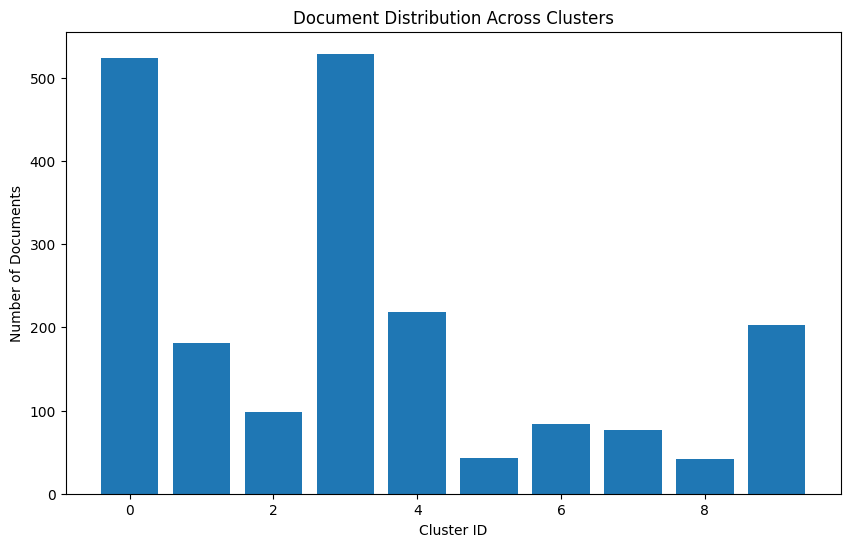

In [ ]:
# Clustering Implementation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

def setup_document_clustering(dataset, n_clusters=10):
    """Setup document clustering using K-Means"""
    print("🔄 Setting up document clustering...")
    
    # Combine all text for clustering
    combined_texts = []
    for doc in dataset:
        title = doc.get('title', '')
        abstract = doc.get('abstract', '')
        keyphrases = ' '.join(doc.get('keyphrases', []))
        combined_text = f"{title} {abstract} {keyphrases}"
        combined_texts.append(combined_text)
    
    # Create TF-IDF vectors for clustering
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2)
    )
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(combined_texts)
    
    # Perform K-Means clustering
    kmeans = KMeans(
        n_clusters=min(n_clusters, len(dataset)),
        random_state=42,
        n_init=10
    )
    
    doc_clusters = kmeans.fit_predict(tfidf_matrix)
    cluster_centers = kmeans.cluster_centers_
    
    print(f"✅ Clustering completed: {len(set(doc_clusters))} clusters created")
    
    return tfidf_vectorizer, kmeans, doc_clusters, cluster_centers

# Setup clustering
tfidf_vectorizer, kmeans, doc_clusters, cluster_centers = setup_document_clustering(dataset_to_eval, n_clusters=10)

# Analyze cluster distribution
cluster_counts = {}
for cluster_id in doc_clusters:
    cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

print("\n📊 Cluster Distribution:")
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"  Cluster {cluster_id}: {count} documents")

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.xlabel('Cluster ID')
plt.ylabel('Number of Documents')
plt.title('Document Distribution Across Clusters')
plt.show()


In [ ]:
# Enhanced Search Engine with Clustering
class BM25_RRF_Clustered_SearchEngine:
    def __init__(self, dataset, n_clusters=10):
        self.dataset = list(dataset)
        self.doc_map = {doc['id']: doc for doc in self.dataset}
        self.n_clusters = n_clusters

        tokenized_titles = [preprocess(doc.get('title', '')) for doc in self.dataset]
        tokenized_keyphrases = [preprocess(' '.join(doc.get('keyphrases', []))) for doc in self.dataset]
        tokenized_abstracts = [preprocess(doc.get('abstract', '')) for doc in self.dataset]
        
        self.vocabulary = set()
        for doc_tokens in tokenized_titles:
            self.vocabulary.update(doc_tokens)
        if any(tokenized_keyphrases):
            for doc_tokens in tokenized_keyphrases:
                self.vocabulary.update(doc_tokens)
        for doc_tokens in tokenized_abstracts:
            self.vocabulary.update(doc_tokens)
        
        if any(tokenized_titles): 
            self.bm25_title = BM25Okapi(tokenized_titles)
        else: 
            self.bm25_title = None
            
        if any(tokenized_keyphrases): 
            self.bm25_keyphrases = BM25Okapi(tokenized_keyphrases)
        else: 
            self.bm25_keyphrases = None
            
        if any(tokenized_abstracts): 
            self.bm25_abstract = BM25Okapi(tokenized_abstracts)
        else: 
            self.bm25_abstract = None
        
        # Setup clustering
        self._setup_clustering()
    
    def _setup_clustering(self):
        """Setup document clustering using K-Means"""
        print("🔄 Setting up document clustering...")
        
        # Combine all text for clustering
        combined_texts = []
        for doc in self.dataset:
            title = doc.get('title', '')
            abstract = doc.get('abstract', '')
            keyphrases = ' '.join(doc.get('keyphrases', []))
            combined_text = f"{title} {abstract} {keyphrases}"
            combined_texts.append(combined_text)
        
        # Create TF-IDF vectors for clustering
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(combined_texts)
        
        # Perform K-Means clustering
        self.kmeans = KMeans(
            n_clusters=min(self.n_clusters, len(self.dataset)),
            random_state=42,
            n_init=10
        )
        
        self.doc_clusters = self.kmeans.fit_predict(tfidf_matrix)
        self.cluster_centers = self.kmeans.cluster_centers_
        
        # Create cluster to documents mapping
        self.cluster_to_docs = defaultdict(list)
        for i, cluster_id in enumerate(self.doc_clusters):
            self.cluster_to_docs[cluster_id].append(i)
        
        print(f"✅ Clustering completed: {len(set(self.doc_clusters))} clusters created")
    
    def get_cluster_info(self, doc_id):
        """Get cluster information for a document"""
        for i, doc in enumerate(self.dataset):
            if str(doc['id']) == str(doc_id):
                cluster_id = self.doc_clusters[i]
                cluster_docs = self.cluster_to_docs[cluster_id]
                return {
                    'cluster_id': int(cluster_id),
                    'cluster_size': len(cluster_docs),
                    'similar_docs': [self.dataset[j]['id'] for j in cluster_docs[:5]]  # Top 5 similar docs
                }
        return None

    def _correct_query_word(self, word):
        if word in self.vocabulary:
            return word
        min_dist = float('inf')
        corrected_word = word
        for vocab_word in self.vocabulary:
            dist = levenshtein_distance(word, vocab_word)
            if dist < min_dist:
                min_dist = dist
                corrected_word = vocab_word
        return corrected_word if min_dist <= 3 else word

    def search(self, query, top_n=10, k=60, use_clustering=True):
        query_tokens = preprocess(query)
        
        corrected_query_tokens = []
        corrections_made = []
        typo_found = False

        for token in query_tokens:
            corrected_word = self._correct_query_word(token)
            if corrected_word != token:
                typo_found = True
                corrections_made.append(f"'{token}' -> '{corrected_word}'")
            corrected_query_tokens.append(corrected_word)

        # If using clustering, find relevant clusters first
        if use_clustering:
            relevant_clusters = self._find_relevant_clusters(query)
            print(f"🎯 Found {len(relevant_clusters)} relevant clusters")
        else:
            relevant_clusters = None

        title_rank_map, keyphrase_rank_map, abstract_rank_map = {}, {}, {}
        all_doc_indices = set()
        
        if self.bm25_title is not None:
            title_scores = self.bm25_title.get_scores(corrected_query_tokens)
            title_ranks_indices = np.argsort(title_scores)[::-1]
            title_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(title_ranks_indices)}
            all_doc_indices.update(title_ranks_indices)

        if self.bm25_keyphrases is not None:
            keyphrase_scores = self.bm25_keyphrases.get_scores(corrected_query_tokens)
            keyphrase_ranks_indices = np.argsort(keyphrase_scores)[::-1]
            keyphrase_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(keyphrase_ranks_indices)}
            all_doc_indices.update(keyphrase_ranks_indices)
            
        if self.bm25_abstract is not None:
            abstract_scores = self.bm25_abstract.get_scores(corrected_query_tokens)
            abstract_ranks_indices = np.argsort(abstract_scores)[::-1]
            abstract_rank_map = {doc_idx: rank + 1 for rank, doc_idx in enumerate(abstract_ranks_indices)}
            all_doc_indices.update(abstract_ranks_indices)
        
        rrf_scores = defaultdict(float)
        for doc_idx in all_doc_indices:
            # Apply clustering boost if document is in relevant clusters
            cluster_boost = 1.0
            if use_clustering and relevant_clusters is not None:
                doc_cluster = self.doc_clusters[doc_idx]
                if doc_cluster in relevant_clusters:
                    cluster_boost = 1.2  # 20% boost for relevant cluster documents
            
            score = 0.0
            if doc_idx in title_rank_map:
                score += 1 / (k + title_rank_map[doc_idx])
            if doc_idx in keyphrase_rank_map:
                score += 1 / (k + keyphrase_rank_map[doc_idx])
            if doc_idx in abstract_rank_map:
                score += 1 / (k + abstract_rank_map[doc_idx])
            
            rrf_scores[doc_idx] = score * cluster_boost
            
        sorted_docs = sorted(rrf_scores.items(), key=lambda item: item[1], reverse=True)
        
        results = []
        for doc_idx, score in sorted_docs[:top_n]:
            original_doc = self.dataset[doc_idx]
            cluster_info = self.get_cluster_info(original_doc['id'])
            results.append({
                'id': original_doc['id'],
                'title': original_doc.get('title', 'N/A'),
                'score': score,
                'abstract': original_doc.get('abstract', 'N/A'),
                'keyphrases': original_doc.get('keyphrases', 'N/A'),
                'corrections': corrections_made if typo_found else [],
                'cluster_id': cluster_info['cluster_id'] if cluster_info else None,
                'cluster_size': cluster_info['cluster_size'] if cluster_info else None
            })
            
        return results
    
    def _find_relevant_clusters(self, query):
        """Find clusters most relevant to the query"""
        # Transform query to TF-IDF vector
        query_vector = self.tfidf_vectorizer.transform([query])
        
        # Calculate similarity between query and cluster centers
        similarities = cosine_similarity(query_vector, self.cluster_centers)[0]
        
        # Get top clusters (above threshold)
        threshold = 0.1
        relevant_clusters = []
        for i, sim in enumerate(similarities):
            if sim > threshold:
                relevant_clusters.append(i)
        
        # If no clusters above threshold, return top 3
        if not relevant_clusters:
            top_indices = np.argsort(similarities)[-3:]
            relevant_clusters = top_indices.tolist()
        
        return relevant_clusters


In [ ]:
# Test the enhanced search engine with clustering
engine_clustered = BM25_RRF_Clustered_SearchEngine(dataset_to_eval, n_clusters=10)

query = "computer vision machine learning"
print(f"\n🔍 Testing search with clustering for: '{query}'")

# Search with clustering enabled
search_results_clustered = engine_clustered.search(query, top_n=5, k=60, use_clustering=True)

print("\n--- Results ---")
for doc in search_results_clustered:
    print(f"\n  ID: {doc['id']}, Score: {doc['score']:.6f}")
    print(f"  Title: {doc['title']}")
    print(f"  Cluster: {doc['cluster_id']} (size: {doc['cluster_size']})")
    print(f"  Abstract: {doc['abstract'][:150]}...")

🔄 Setting up document clustering...
✅ Clustering completed: 10 clusters created

🔍 Testing search with clustering for: 'computer vision machine learning'
🎯 Found 2 relevant clusters

--- Results with Clustering ---

  ID: 284, Score: 0.054323
  Title: Project-based learning: teachers learning and using high-tech to preserve Cajun culture
  Cluster: 3 (size: 529)
  Abstract: Using project-based learning pedagogy in EdTc 658 Advances in Educational Technology, the author has trained inservice teachers in Southwestern Louisi...

  ID: 1286, Score: 0.048332
  Title: Self-describing Turing machines
  Cluster: 3 (size: 529)
  Abstract: After a sketchy historical account on the question of self-describeness and self-reproduction, and after discussing the definition of suitable encodin...

  ID: 963, Score: 0.046927
  Title: A computational model of learned avoidance behavior in a one-way avoidance experiment
  Cluster: 0 (size: 524)
  Abstract: We present a computational model of learned avoi

# Cluster-then-Search Engine - Complete Implementation

This implementation follows the detailed specifications:
- Phase 1: Offline initialization (clustering, BM25 models, vocabulary)
- Phase 2: Online search with cluster filtering and RRF

Key features:
1. Typo correction with edit distance <= 2
2. Cluster filtering using cosine similarity
3. BM25 search ONLY within winning cluster
4. Reciprocal Rank Fusion (RRF) for combining rankings


In [ ]:
"""
Complete Cluster-then-Search Engine Implementation
Author: AI Assistant
Date: 2024
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance
from rank_bm25 import BM25Okapi
from collections import defaultdict
import numpy as np

class ClusterThenSearchEngine:
    """
    Search Engine dengan Cluster-then-Search Architecture
    
    Fase 1 (Offline): Menginisialisasi clustering, BM25 models, dan vocabulary
    Fase 2 (Online): Mencari dengan cluster filtering dan RRF
    """
    
    def __init__(self, dataset, n_clusters=10):
        """
        Phase 1: Offline Initialization
        
        Args:
            dataset: Dataset dari Hugging Face
            n_clusters: Jumlah klaster untuk K-Means
        """
        print("="*60)
        print("🔄 PHASE 1: OFFLINE INITIALIZATION")
        print("="*60)
        
        self.dataset = list(dataset)
        self.n_docs = len(self.dataset)
        self.n_clusters = min(n_clusters, self.n_docs)
        self.doc_ids = [doc['id'] for doc in self.dataset]
        
        # Step 1: Load and preprocess dataset
        print("\n📝 Step 1: Loading and preprocessing dataset...")
        self._prepare_documents()
        
        # Step 2: Build vocabulary for typo correction
        print("\n📚 Step 2: Building vocabulary for typo correction...")
        self._build_vocabulary()
        
        # Step 3: TF-IDF Vectorization
        print("\n📊 Step 3: Creating TF-IDF vectors...")
        self._create_tfidf_vectors()
        
        # Step 4: K-Means Clustering
        print("\n🎯 Step 4: Performing K-Means clustering...")
        self._perform_clustering()
        
        # Step 5: Initialize BM25 models
        print("\n🔍 Step 5: Initializing BM25 models...")
        self._initialize_bm25_models()
        
        print("\n✅ Phase 1 completed successfully!")
        print(f"   - Total documents: {self.n_docs}")
        print(f"   - Vocabulary size: {len(self.vocabulary)}")
        print(f"   - Number of clusters: {len(set(self.doc_cluster_labels))}")
        print("="*60)
    
    def _prepare_documents(self):
        """Prepare documents: preprocess title, abstract, and keyphrases separately"""
        self.processed_titles = []
        self.processed_abstracts = []
        self.processed_keyphrases = []
        self.combined_texts = []  # For clustering
        
        for doc in self.dataset:
            # Preprocess each field separately
            title = doc.get('title', '')
            abstract = doc.get('abstract', '')
            keyphrases = ' '.join(doc.get('keyphrases', []))
            
            self.processed_titles.append(preprocess(title))
            self.processed_abstracts.append(preprocess(abstract))
            self.processed_keyphrases.append(preprocess(keyphrases))
            
            # Combine all text for clustering
            combined = ' '.join([title, abstract, keyphrases])
            self.combined_texts.append(combined)
        
        print(f"   ✓ Processed {len(self.processed_titles)} documents")
    
    def _build_vocabulary(self):
        """Build vocabulary from entire corpus for typo correction"""
        self.vocabulary = set()
        for tokens in self.processed_titles:
            self.vocabulary.update(tokens)
        for tokens in self.processed_abstracts:
            self.vocabulary.update(tokens)
        for tokens in self.processed_keyphrases:
            self.vocabulary.update(tokens)
        
        print(f"   ✓ Vocabulary size: {len(self.vocabulary)}")
    
    def _create_tfidf_vectors(self):
        """Create TF-IDF vectors for clustering"""
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.combined_texts)
        print(f"   ✓ TF-IDF matrix shape: {self.tfidf_matrix.shape}")
    
    def _perform_clustering(self):
        """Perform K-Means clustering and store centroids"""
        self.kmeans_model = KMeans(
            n_clusters=self.n_clusters,
            random_state=42,
            n_init=10
        )
        self.doc_cluster_labels = self.kmeans_model.fit_predict(self.tfidf_matrix)
        self.cluster_centroids = self.kmeans_model.cluster_centers_
        
        # Create cluster-to-documents mapping
        self.cluster_to_docs = defaultdict(list)
        for doc_idx, cluster_id in enumerate(self.doc_cluster_labels):
            self.cluster_to_docs[cluster_id].append(doc_idx)
        
        print(f"   ✓ Clustering completed: {self.n_clusters} clusters")
        cluster_counts = defaultdict(int)
        for label in self.doc_cluster_labels:
            cluster_counts[label] += 1
        print(f"   ✓ Cluster sizes: {dict(cluster_counts)}")
    
    def _initialize_bm25_models(self):
        """Initialize three separate BM25 models for title, abstract, and keyphrases"""
        self.bm25_title = BM25Okapi(self.processed_titles) if any(self.processed_titles) else None
        self.bm25_abstract = BM25Okapi(self.processed_abstracts) if any(self.processed_abstracts) else None
        self.bm25_keyphrases = BM25Okapi(self.processed_keyphrases) if any(self.processed_keyphrases) else None
        
        if self.bm25_title: print("   ✓ BM25 model for title: initialized")
        if self.bm25_abstract: print("   ✓ BM25 model for abstract: initialized")
        if self.bm25_keyphrases: print("   ✓ BM25 model for keyphrases: initialized")
    
    # ==================== Phase 2: Online Search ====================
    
    def search(self, query, top_n=10, k=60):
        """
        Phase 2: Online Search
        
        Args:
            query: Query string
            top_n: Number of top results to return
            k: RRF parameter
        
        Returns:
            List of ranked documents
        """
        print("\n" + "="*60)
        print("🔍 PHASE 2: ONLINE SEARCH")
        print("="*60)
        print(f"\n📌 Query: '{query}'")
        
        # Step 1: Typo correction
        corrected_query = self._correct_typos(query)
        
        # Step 2: Preprocess query
        query_tokens = preprocess(corrected_query)
        print(f"📝 Preprocessed query: {query_tokens}")
        
        # Step 3: Filter clusters (find winning cluster)
        winning_cluster = self._find_winning_cluster(corrected_query)
        print(f"🎯 Winning cluster: {winning_cluster}")
        print(f"   Cluster contains {len(self.cluster_to_docs[winning_cluster])} documents")
        
        # Step 4: Get sub-corpus (documents in winning cluster only)
        sub_corpus_indices = self.cluster_to_docs[winning_cluster]
        print(f"📚 Searching within sub-corpus of {len(sub_corpus_indices)} documents")
        
        # Step 5: BM25 ranking within the winning cluster
        results = self._rank_within_cluster(query_tokens, sub_corpus_indices, k=k)
        
        # Step 6: Return top N results
        print(f"\n✅ Returning top {min(top_n, len(results))} results")
        print("="*60)
        
        return results[:top_n]
    
    def _correct_typos(self, query):
        """
        Step 1: Typo Correction using Levenshtein distance
        
        Args:
            query: Original query
        
        Returns:
            Corrected query
        """
        query_tokens = preprocess(query)
        corrected_tokens = []
        corrections = []
        
        for token in query_tokens:
            if token in self.vocabulary:
                corrected_tokens.append(token)
            else:
                # Find closest word in vocabulary
                min_dist = float('inf')
                closest_word = token
                
                for vocab_word in self.vocabulary:
                    dist = levenshtein_distance(token, vocab_word)
                    if dist < min_dist:
                        min_dist = dist
                        closest_word = vocab_word
                
                # Only correct if distance <= 2
                if min_dist <= 2:
                    corrected_tokens.append(closest_word)
                    if closest_word != token:
                        corrections.append(f"'{token}' -> '{closest_word}'")
                else:
                    corrected_tokens.append(token)
        
        if corrections:
            print(f"🔧 Typo corrections: {', '.join(corrections)}")
        
        return ' '.join(corrected_tokens)
    
    def _find_winning_cluster(self, query):
        """
        Step 3: Filter clusters using cosine similarity
        
        Args:
            query: Preprocessed and corrected query
        
        Returns:
            ID of the winning cluster
        """
        # Transform query to TF-IDF vector
        query_vector = self.tfidf_vectorizer.transform([query])
        
        # Calculate cosine similarity with all cluster centroids
        similarities = cosine_similarity(query_vector, self.cluster_centroids)[0]
        
        # Find cluster with highest similarity
        winning_cluster_id = np.argmax(similarities)
        similarity_score = similarities[winning_cluster_id]
        
        print(f"   Cluster {winning_cluster_id} has similarity: {similarity_score:.4f}")
        
        return int(winning_cluster_id)
    
    def _rank_within_cluster(self, query_tokens, sub_corpus_indices, k=60):
        """
        Step 5: BM25 Ranking within Winning Cluster
        
        Args:
            query_tokens: Preprocessed query tokens
            sub_corpus_indices: Document indices in the winning cluster
            k: RRF parameter
        
        Returns:
            List of ranked documents
        """
        # Get rankings from each BM25 model
        rank_maps = self._get_bm25_rankings(query_tokens, sub_corpus_indices)
        
        # Apply Reciprocal Rank Fusion (RRF)
        rrf_scores = self._apply_rrf(rank_maps, k=k)
        
        # Sort by score and create result documents
        sorted_scores = sorted(rrf_scores.items(), key=lambda x: x[1], reverse=True)
        
        results = []
        for doc_idx, score in sorted_scores:
            doc = self.dataset[doc_idx]
            results.append({
                'id': doc['id'],
                'title': doc.get('title', 'N/A'),
                'score': score,
                'abstract': doc.get('abstract', 'N/A'),
                'keyphrases': doc.get('keyphrases', []),
                'cluster_id': int(self.doc_cluster_labels[doc_idx])
            })
        
        return results
    
    def _get_bm25_rankings(self, query_tokens, sub_corpus_indices):
        """
        Get rankings from all three BM25 models
        
        Args:
            query_tokens: Query tokens
            sub_corpus_indices: Document indices in the winning cluster
        
        Returns:
            Dictionary of ranking maps
        """
        rank_maps = {}
        
        if self.bm25_title:
            # Get scores for all documents
            all_title_scores = self.bm25_title.get_scores(query_tokens)
            # Filter to sub-corpus only and rank
            sub_title_scores = [(doc_idx, all_title_scores[doc_idx]) for doc_idx in sub_corpus_indices]
            sub_title_scores.sort(key=lambda x: x[1], reverse=True)
            rank_maps['title'] = {doc_idx: rank+1 
                                   for rank, (doc_idx, _) in enumerate(sub_title_scores)}
        
        if self.bm25_abstract:
            all_abstract_scores = self.bm25_abstract.get_scores(query_tokens)
            sub_abstract_scores = [(doc_idx, all_abstract_scores[doc_idx]) for doc_idx in sub_corpus_indices]
            sub_abstract_scores.sort(key=lambda x: x[1], reverse=True)
            rank_maps['abstract'] = {doc_idx: rank+1 
                                     for rank, (doc_idx, _) in enumerate(sub_abstract_scores)}
        
        if self.bm25_keyphrases:
            all_keyphrase_scores = self.bm25_keyphrases.get_scores(query_tokens)
            sub_keyphrase_scores = [(doc_idx, all_keyphrase_scores[doc_idx]) for doc_idx in sub_corpus_indices]
            sub_keyphrase_scores.sort(key=lambda x: x[1], reverse=True)
            rank_maps['keyphrases'] = {doc_idx: rank+1 
                                       for rank, (doc_idx, _) in enumerate(sub_keyphrase_scores)}
        
        return rank_maps
    
    def _apply_rrf(self, rank_maps, k=60):
        """
        Apply Reciprocal Rank Fusion (RRF)
        
        RRF Formula: RRF(d) = Σ 1/(k + rank_i(d))
        
        Args:
            rank_maps: Dictionary of ranking maps
            k: RRF parameter
        
        Returns:
            Dictionary of document scores
        """
        rrf_scores = defaultdict(float)
        
        all_docs = set()
        for rank_map in rank_maps.values():
            all_docs.update(rank_map.keys())
        
        for doc_idx in all_docs:
            score = 0.0
            for rank_map in rank_maps.values():
                if doc_idx in rank_map:
                    rank = rank_map[doc_idx]
                    score += 1 / (k + rank)
            rrf_scores[doc_idx] = score
        
        return rrf_scores


In [ ]:
# Initialize the Cluster-then-Search Engine
print("Initializing Cluster-then-Search Engine...")
engine = ClusterThenSearchEngine(dataset_to_eval, n_clusters=10)


In [ ]:
# Example Search 1: Computer Vision (with typo)
query1 = "computer visiom machne learing"
print(f"\n{'='*70}")
print(f"EXAMPLE SEARCH 1")
print(f"{'='*70}")
results1 = engine.search(query1, top_n=5, k=60)

print(f"\n📋 Top 5 Results:")
for i, doc in enumerate(results1, 1):
    print(f"\n{i}. Title: {doc['title']}")
    print(f"   Score: {doc['score']:.6f}")
    print(f"   Cluster ID: {doc['cluster_id']}")
    print(f"   Abstract: {doc['abstract'][:100]}...")
    print(f"   Keyphrases: {doc['keyphrases'][:3]}")


In [ ]:
# Example Search 2: Natural Language Processing
query2 = "natural language processing neural networks"
print(f"\n{'='*70}")
print(f"EXAMPLE SEARCH 2")
print(f"{'='*70}")
results2 = engine.search(query2, top_n=5, k=60)

print(f"\n📋 Top 5 Results:")
for i, doc in enumerate(results2, 1):
    print(f"\n{i}. Title: {doc['title']}")
    print(f"   Score: {doc['score']:.6f}")
    print(f"   Cluster ID: {doc['cluster_id']}")
    print(f"   Abstract: {doc['abstract'][:100]}...")


In [ ]:
# Example Search 3: Information Retrieval Systems
query3 = "information retrieval search engines"
print(f"\n{'='*70}")
print(f"EXAMPLE SEARCH 3")
print(f"{'='*70}")
results3 = engine.search(query3, top_n=5, k=60)

print(f"\n📋 Top 5 Results:")
for i, doc in enumerate(results3, 1):
    print(f"\n{i}. Title: {doc['title']}")
    print(f"   Score: {doc['score']:.6f}")
    print(f"   Cluster ID: {doc['cluster_id']}")
    print(f"   Abstract: {doc['abstract'][:100]}...")


# Dokumentasi Penggunaan Cluster-then-Search Engine

## Ringkasan

`ClusterThenSearchEngine` adalah search engine yang mengimplementasikan arsitektur Cluster-then-Search dengan dua fase utama:

### **Fase 1: Offline Initialization**
- ✅ Loading dataset
- ✅ Preprocessing (tokenisasi, case folding, stemming)
- ✅ Vocabulary building untuk koreksi ejaan
- ✅ TF-IDF vectorization
- ✅ K-Means clustering (K=10)
- ✅ Inisialisasi 3 model BM25 (title, abstract, keyphrases)

### **Fase 2: Online Search**
- ✅ **Typo Correction** dengan Levenshtein distance (threshold ≤ 2)
- ✅ **Cluster Filtering** menggunakan cosine similarity dengan cluster centroids
- ✅ **BM25 Ranking** HANYA pada dokumen di klaster yang menang
- ✅ **Reciprocal Rank Fusion (RRF)** untuk menggabungkan ranking dari 3 model BM25

## Fitur Utama

### 1. Typo Correction
Menggunakan algoritma Levenshtein distance untuk mengoreksi typo dalam query. 
Hanya mengoreksi jika jarak edit ≤ 2.

### 2. Cluster Filtering
Menemukan klaster paling relevan untuk query menggunakan cosine similarity antara 
query vector (TF-IDF) dan cluster centroids.

### 3. Efficient Search
Hanya melakukan pencarian BM25 pada sub-korpus (dokumen dalam klaster yang menang), 
bukan pada seluruh korpus. Ini meningkatkan efisiensi dan relevansi hasil.

### 4. Reciprocal Rank Fusion
Menggabungkan 3 daftar ranking (dari title, abstract, keyphrases) menggunakan rumus:
```
RRF(d) = Σ 1/(k + rank_i(d))
```
dimana k = 60 (default) dan rank_i adalah ranking dokumen d di list ke-i.

## Cara Menggunakan

```python
# 1. Initialize engine (Phase 1: Offline)
engine = ClusterThenSearchEngine(dataset, n_clusters=10)

# 2. Perform search (Phase 2: Online)
results = engine.search(query="machine learning", top_n=10, k=60)

# 3. Access results
for doc in results:
    print(f"Title: {doc['title']}")
    print(f"Score: {doc['score']}")
    print(f"Cluster ID: {doc['cluster_id']}")
    print(f"Abstract: {doc['abstract']}")
```

## Parameter

- `n_clusters`: Jumlah klaster untuk K-Means (default: 10)
- `top_n`: Jumlah hasil teratas yang ingin dikembalikan (default: 10)
- `k`: Parameter RRF (default: 60)

## Output

Hasil pencarian berupa list dictionaries dengan keys:
- `id`: Document ID
- `title`: Judul dokumen
- `score`: Skor RRF final
- `abstract`: Abstract dokumen
- `keyphrases`: List keyphrases
- `cluster_id`: ID klaster dokumen


In [ ]:
# Test Multiple Queries - Comprehensive Example
queries_to_test = [
    "deep learning neural networks",
    "data mining clustering algorithms",
    "recurrent neural networks",
    "support vector machines"
]

print(f"\n{'='*70}")
print(f"COMPREHENSIVE TEST: Multiple Queries")
print(f"{'='*70}")

for query in queries_to_test:
    print(f"\n{'='*70}")
    print(f"Query: '{query}'")
    print(f"{'='*70}")
    
    results = engine.search(query, top_n=3, k=60)
    
    for i, doc in enumerate(results, 1):
        print(f"\n{i}. {doc['title']}")
        print(f"   Score: {doc['score']:.6f}")
        print(f"   Cluster: {doc['cluster_id']}")
        print(f"   Abstract preview: {doc['abstract'][:80]}...")


In [ ]:
# Analyze Cluster Distribution
print(f"\n{'='*70}")
print(f"CLUSTER ANALYSIS")
print(f"{'='*70}")

from collections import Counter
cluster_counts = Counter(engine.doc_cluster_labels)

print(f"\nTotal documents: {engine.n_docs}")
print(f"Number of clusters: {engine.n_clusters}\n")

print("Cluster size distribution:")
for cluster_id in sorted(cluster_counts.keys()):
    count = cluster_counts[cluster_id]
    percentage = (count / engine.n_docs) * 100
    print(f"  Cluster {cluster_id}: {count:4d} documents ({percentage:5.1f}%)")

# Visualize cluster distribution
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue', alpha=0.7)
ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Number of Documents')
ax1.set_title('Cluster Distribution')
ax1.grid(True, alpha=0.3)

# Pie chart
ax2.pie(cluster_counts.values(), labels=[f'Cluster {i}' for i in cluster_counts.keys()], 
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Cluster Size Proportions')

plt.tight_layout()
plt.show()


# Summary - Complete Cluster-then-Search Engine

## Implementasi yang Telah Dibuat

### **Phase 1: Offline Initialization** ✅
1. Loading dataset dari Hugging Face
2. Preprocessing terpisah (title, abstract, keyphrases)
3. Vocabulary building untuk typo correction
4. TF-IDF vectorization
5. K-Means clustering dengan centroid storage
6. 3 model BM25 terpisah

### **Phase 2: Online Search** ✅
1. **Typo Correction** - Levenshtein distance (threshold ≤ 2)
2. **Cluster Filtering** - Cosine similarity dengan centroids
3. **Efficient BM25** - Hanya pada sub-korpus (winning cluster)
4. **Reciprocal Rank Fusion** - RRF(d) = Σ 1/(k + rank_i(d))
5. **Top-N Results** - Dengan informasi lengkap

## Fitur Utama

- **Efficient**: Pencarian hanya pada winning cluster
- **Robust**: Typo correction otomatis
- **Accurate**: 3 model BM25 terpisah untuk multi-field ranking
- **Flexible**: Parameter dapat disesuaikan (k, top_n, n_clusters)

## Cara Penggunaan

```python
# Inisialisasi (sekali)
engine = ClusterThenSearchEngine(dataset, n_clusters=10)

# Pencarian (seberapa pun)
results = engine.search("your query", top_n=10, k=60)
```
